<a href="https://colab.research.google.com/github/moshimoshisama/Expedia_Analysis/blob/main/5_ensemble_NB_models_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook takes the sampled data and train 5 ensemble models and 3 Naive Bayes models on click through and transaction perdictions

# **Part I: Data read in**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Read in all sampled data
top10 = pd.read_csv("/content/drive/MyDrive/expedia/source/top1_0_data.csv",sep=",")
top11 = pd.read_csv("/content/drive/MyDrive/expedia/source/top1_1_sample_data.csv",sep=",")
top21 = pd.read_csv("/content/drive/MyDrive/expedia/source/top2_1_sample.csv",sep=",")
top20 = pd.read_csv("/content/drive/MyDrive/expedia/source/top2_0_sample_data.csv",sep=",")
top3 = pd.read_csv("/content/drive/MyDrive/expedia/source/top3_sample.csv",sep=",")

In [4]:
top_list = [top10,top11,top21,top20,top3]

In [5]:
top_all = pd.concat(top_list)

In [6]:
amenities = pd.read_csv("drive/MyDrive/expedia/source/amenities.tsv",sep="\t")

In [7]:
top_all_merge = top_all.merge(amenities,on=['prop_id'], how='left')

In [ ]:
top_all_merge.dtypes

user_id                       object
search_id                     object
search_timestamp              object
point_of_sale                  int64
geo_location_country           int64
is_mobile                      int64
destination_id                 int64
checkin_date                  object
checkout_date                 object
adult_count                    int64
child_count                    int64
infant_count                   int64
room_count                     int64
sort_type                     object
applied_filters               object
impressions                   object
year_month                    object
year                         float64
month                        float64
rank                           int64
prop_id                        int64
is_travel_ad                   int64
review_rating                float64
review_count                 float64
star_rating                  float64
is_free_cancellation           int64
is_drr                         int64
p

In [ ]:
# count for positive click through instances
top_all_merge[top_all_merge.is_clicked == True].count()

user_id                      802820
search_id                    802820
search_timestamp             802820
point_of_sale                802820
geo_location_country         802820
is_mobile                    802820
destination_id               802820
checkin_date                 802820
checkout_date                802820
adult_count                  802820
child_count                  802820
infant_count                 802820
room_count                   802820
sort_type                    802820
applied_filters              206501
impressions                  802820
year_month                   802820
year                         802820
month                        802820
rank                         802820
prop_id                      802820
is_travel_ad                 802820
review_rating                802309
review_count                 802309
star_rating                  744405
is_free_cancellation         802820
is_drr                       802820
price_bucket                

In [ ]:
# count for negative click through instances
top_all_merge[top_all_merge.is_clicked == False].count()

user_id                      738343
search_id                    738343
search_timestamp             738343
point_of_sale                738343
geo_location_country         738343
is_mobile                    738343
destination_id               738343
checkin_date                 738335
checkout_date                738335
adult_count                  738343
child_count                  738343
infant_count                 738343
room_count                   738343
sort_type                    738343
applied_filters              200435
impressions                  738343
year_month                   738335
year                         738335
month                        738335
rank                         738343
prop_id                      738343
is_travel_ad                 738343
review_rating                737825
review_count                 737825
star_rating                  538643
is_free_cancellation         738343
is_drr                       738343
price_bucket                

In [ ]:
# count for positive transaction instances
top_all_merge[top_all_merge.is_trans == True].count()

user_id                      75084
search_id                    75084
search_timestamp             75084
point_of_sale                75084
geo_location_country         75084
is_mobile                    75084
destination_id               75084
checkin_date                 75084
checkout_date                75084
adult_count                  75084
child_count                  75084
infant_count                 75084
room_count                   75084
sort_type                    75084
applied_filters              16223
impressions                  75084
year_month                   75084
year                         75084
month                        75084
rank                         75084
prop_id                      75084
is_travel_ad                 75084
review_rating                74963
review_count                 74963
star_rating                  74564
is_free_cancellation         75084
is_drr                       75084
price_bucket                 70603
num_clicks          

# **Part II: Data prepocessing and resampling**

In [8]:
# only keep property and amenity related features, drop the others
top_all_merge = top_all_merge.drop(['user_id','search_id','search_timestamp','point_of_sale','is_mobile',\
                  'geo_location_country','destination_id','checkin_date',\
                  'checkout_date','adult_count','child_count','infant_count','room_count','impressions','year_month',\
                  'year','month','prop_id','num_clicks','applied_filters','sort_type'\
                  ],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [9]:
top_all_merge = top_all_merge.fillna(0)

In [ ]:
# features after drop
top_all_merge.dtypes

is_travel_ad                   int64
review_rating                float64
star_rating                  float64
is_free_cancellation           int64
is_drr                         int64
price_bucket                 float64
is_trans                       int64
is_clicked                     int64
AirConditioning              float64
AirportTransfer              float64
Bar                          float64
FreeAirportTransportation    float64
FreeBreakfast                float64
FreeParking                  float64
FreeWiFi                     float64
Gym                          float64
HighSpeedInternet            float64
HotTub                       float64
LaundryFacility              float64
Parking                      float64
PetsAllowed                  float64
PrivatePool                  float64
SpaServices                  float64
SwimmingPool                 float64
WasherDryer                  float64
WiFi                         float64
dtype: object

In [15]:
# Resampled transaction instances, number of negative instance match with positive instance
import numpy as np

book_indices = top_all_merge[top_all_merge.is_trans == 1].index
random_indices = np.random.choice(book_indices, len(top_all_merge.loc[top_all_merge.is_trans == 1]), replace=False)
book_sample = top_all_merge.loc[random_indices]

not_booked = top_all_merge[top_all_merge.is_trans == 0].index
random_indices = np.random.choice(not_booked, len(top_all_merge.loc[top_all_merge.is_trans == 1]), replace=False)
not_book_sample = top_all_merge.loc[random_indices]

trans_sample_data = pd.concat([not_book_sample, book_sample], axis=0)

print("Percentage of not book impressions: ", len(trans_sample_data[trans_sample_data.is_trans == 0])/len(trans_sample_data))
print("Percentage of book impression: ", len(trans_sample_data[trans_sample_data.is_trans == 1])/len(trans_sample_data))
print("Total number of records in resampled data: ", len(trans_sample_data))

Percentage of not book impressions:  0.5
Percentage of book impression:  0.5
Total number of records in resampled data:  150168


In [16]:
# since we already have less negative click through instance, we do not apply resampled and directly use it as train/test dataset
print("Percentage of not click impressions: ", len(top_all_merge[top_all_merge.is_clicked == 0])/len(top_all_merge))
print("Percentage of click impression: ", len(top_all_merge[top_all_merge.is_clicked == 1])/len(top_all_merge))
print("Total number of records in resampled data: ", len(top_all_merge))

Percentage of not click impressions:  0.4790817064775108
Percentage of click impression:  0.5209182935224892
Total number of records in resampled data:  1541163


# **Part III: Grid Search Parameter & Ensemble Models Training**

In [10]:
# identify predict result Y values
Y1 = trans_sample_data['is_trans'].values
Y2 = top_all_merge['is_clicked'].values

In [11]:
# identify X values
top_all_merge=top_all_merge.drop(['is_trans','is_clicked'],1)
trans_sample_data=trans_sample_data.drop(['is_trans','is_clicked'],1)
X1 = trans_sample_data.values
X2 = top_all_merge.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [12]:
# import ensembled and Naive Bayes models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [13]:
# split the dataset into 70% training and 30% testing
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,Y1,test_size=0.3,random_state=1)
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,Y2,test_size=0.3,random_state=1)


In [24]:
# we use grid search to fine tune the parameter, init_ensemble function is the initial parameters that we have for each ensemble models
def init_ensemble():
    rf =RandomForestClassifier(random_state=40)
    bagg = BaggingClassifier(random_state=40)
    extra = ExtraTreesClassifier(random_state=40)
    ada = AdaBoostClassifier(random_state=40)
    grad = GradientBoostingClassifier(random_state=40)
    classifier_list = [rf,bagg,extra,ada,grad]
    classifier_name_list = ['Random Forests','Bagging','Extra Trees','AdaBoost','Gradient Boost']
    classifier_list = [extra,ada,grad]
    classifier_name_list = ['Extra Trees','AdaBoost','Gradient Boost']
    return classifier_list,classifier_name_list

In [25]:
# grid search function
def grid_search_ensemble(trained_model,trained_model_name,X_train,y_train):
    print('--------- Model : ', trained_model_name, ' ---------------\n')
    param_test1 = {'n_estimators':range(50,131,20)}
    gsearch1 = GridSearchCV(estimator = trained_model,
                       param_grid = param_test1, scoring='roc_auc',cv=5)

    gsearch1.fit(X_train,y_train)
    print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)
    print("---------------------------------------\n")

In [ ]:
# grid search for parameter in transaction dataset 
classifier_list, classifier_name_list = init_ensemble()
for classifier,classifier_name in zip(classifier_list,classifier_name_list):
    grid_search_ensemble(classifier,classifier_name,X1_train,y1_train)

--------- Model :  Random Forests  ---------------

{'mean_fit_time': array([ 4.65974693,  6.48595743,  8.40189071, 10.41962638, 11.89718542]), 'std_fit_time': array([0.09385643, 0.06019939, 0.04631809, 0.27506814, 0.12377632]), 'mean_score_time': array([0.44501867, 0.62258563, 0.80007019, 0.98556285, 1.12737141]), 'std_score_time': array([0.01115817, 0.01241301, 0.01380099, 0.02902238, 0.00846948]), 'param_n_estimators': masked_array(data=[50, 70, 90, 110, 130],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 50}, {'n_estimators': 70}, {'n_estimators': 90}, {'n_estimators': 110}, {'n_estimators': 130}], 'split0_test_score': array([0.66884158, 0.67003161, 0.67014577, 0.67029703, 0.67011042]), 'split1_test_score': array([0.67240753, 0.67301247, 0.67371027, 0.67395938, 0.67420254]), 'split2_test_score': array([0.66907291, 0.66953579, 0.66993411, 0.67000683, 0.67019732]), 'split3_test_score': array([0.669

In [ ]:
# grid search for parameter in click through dataset 
classifier_list, classifier_name_list = init_ensemble()
for classifier,classifier_name in zip(classifier_list,classifier_name_list):
    grid_search_ensemble(classifier,classifier_name,X2_train,y2_train)

--------- Model :  Random Forests  ---------------

{'mean_fit_time': array([109.25745611, 152.68746724, 190.71161962, 223.35603671,
       243.18492603]), 'std_fit_time': array([2.1760785 , 2.33909556, 3.37419131, 6.07612459, 4.99640828]), 'mean_score_time': array([ 6.68425484,  8.82783031, 11.03025556, 13.31992264, 15.39602337]), 'std_score_time': array([0.72059813, 0.17437247, 0.10322079, 0.15324446, 0.54794681]), 'param_n_estimators': masked_array(data=[50, 70, 90, 110, 130],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 50}, {'n_estimators': 70}, {'n_estimators': 90}, {'n_estimators': 110}, {'n_estimators': 130}], 'split0_test_score': array([0.71701721, 0.71735607, 0.71741106, 0.71759263, 0.71771022]), 'split1_test_score': array([0.7173805 , 0.71776198, 0.71791705, 0.71803108, 0.71805384]), 'split2_test_score': array([0.71747161, 0.71779669, 0.71794049, 0.71810255, 0.71812962]), 'split3_test_sco

In [26]:
# grid search for parameter in click through dataset 
classifier_list, classifier_name_list = init_ensemble()
for classifier,classifier_name in zip(classifier_list,classifier_name_list):
    grid_search_ensemble(classifier,classifier_name,X2_train,y2_train)

--------- Model :  Extra Trees  ---------------

{'mean_fit_time': array([105.39956856, 135.71173911, 176.50132217, 210.31603861,
       257.03138881]), 'std_fit_time': array([6.08283947, 3.43803221, 2.65431916, 4.28201282, 5.39463748]), 'mean_score_time': array([ 7.12734246,  9.37777801, 12.5305624 , 14.8128933 , 18.13384676]), 'std_score_time': array([0.18961381, 0.31709999, 0.36042902, 1.04784793, 0.82113961]), 'param_n_estimators': masked_array(data=[50, 70, 90, 110, 130],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 50}, {'n_estimators': 70}, {'n_estimators': 90}, {'n_estimators': 110}, {'n_estimators': 130}], 'split0_test_score': array([0.70810123, 0.70820718, 0.70832593, 0.70835839, 0.70836242]), 'split1_test_score': array([0.70851279, 0.70854803, 0.70860178, 0.70864898, 0.70867647]), 'split2_test_score': array([0.70828571, 0.70842335, 0.70848852, 0.70850329, 0.70848407]), 'split3_test_score'

In [ ]:
# ensemble models with fine tune parameters for transaction perdiction
def get_ensemble_models_trans():
    rf =RandomForestClassifier(n_estimators=130,min_samples_leaf=5,min_samples_split=3,random_state=40)
    bagg = BaggingClassifier(n_estimators=130,random_state=40)
    extra = ExtraTreesClassifier(n_estimators=130,random_state=40)
    ada = AdaBoostClassifier(n_estimators=130,random_state=40)
    grad = GradientBoostingClassifier(n_estimators=130,random_state=40)
    classifier_list = [rf,bagg,extra,ada,grad]
    classifier_name_list = ['Random Forests','Bagging','Extra Trees','AdaBoost','Gradient Boost']
    return classifier_list,classifier_name_list

In [14]:
# ensemble models with fine tune parameters for click through perdiction
def get_ensemble_models_clicked():
    rf =RandomForestClassifier(n_estimators=130,min_samples_leaf=5,min_samples_split=3,random_state=40)
    bagg = BaggingClassifier(n_estimators=130,random_state=40)
    extra = ExtraTreesClassifier(n_estimators=130,random_state=40)
    ada = AdaBoostClassifier(n_estimators=130,random_state=40)
    grad = GradientBoostingClassifier(n_estimators=130,random_state=40)
    classifier_list = [rf,bagg,extra,ada,grad]
    classifier_name_list = ['Random Forests','Bagging','Extra Trees','AdaBoost','Gradient Boost']
    return classifier_list,classifier_name_list

In [15]:
# evaluation metrics print out function
def print_evaluation_metrics(trained_model,trained_model_name,X_test,y_test):
    print('--------- Model : ', trained_model_name, ' ---------------\n')
    predicted_values = trained_model.predict(X_test)
    print(metrics.classification_report(y_test,predicted_values))
    print("Accuracy Score : ",metrics.accuracy_score(y_test,predicted_values))
    print("---------------------------------------\n")

In [ ]:
# ensemble model training for trasaction prediction
classifier_list, classifier_name_list = get_ensemble_models_trans()
for classifier,classifier_name in zip(classifier_list,classifier_name_list):
    classifier.fit(X1_train,y1_train)
    print_evaluation_metrics(classifier,classifier_name,X1_test,y1_test)

--------- Model :  Random Forests  ---------------

              precision    recall  f1-score   support

           0       0.74      0.51      0.61     22655
           1       0.63      0.82      0.71     22396

    accuracy                           0.67     45051
   macro avg       0.68      0.67      0.66     45051
weighted avg       0.68      0.67      0.66     45051

Accuracy Score :  0.6663115136178998
---------------------------------------

--------- Model :  Bagging  ---------------

              precision    recall  f1-score   support

           0       0.67      0.58      0.62     22655
           1       0.63      0.71      0.66     22396

    accuracy                           0.64     45051
   macro avg       0.65      0.64      0.64     45051
weighted avg       0.65      0.64      0.64     45051

Accuracy Score :  0.6440034627422255
---------------------------------------

--------- Model :  Extra Trees  ---------------

              precision    recall  f1-score 

In [ ]:
# ensemble model training for click through prediction
classifier_list, classifier_name_list = get_ensemble_models_clicked()
for classifier,classifier_name in zip(classifier_list,classifier_name_list):
    classifier.fit(X2_train,y2_train)
    print_evaluation_metrics(classifier,classifier_name,X2_test,y2_test)

--------- Model :  Random Forests  ---------------

              precision    recall  f1-score   support

           0       0.75      0.76      0.75    220991
           1       0.78      0.76      0.77    241358

    accuracy                           0.76    462349
   macro avg       0.76      0.76      0.76    462349
weighted avg       0.76      0.76      0.76    462349

Accuracy Score :  0.7628869101047044
---------------------------------------



KeyboardInterrupt: ignored

In [ ]:
# ensemble model training for click through prediction
classifier_list, classifier_name_list = get_ensemble_models_clicked()
for classifier,classifier_name in zip(classifier_list,classifier_name_list):
    classifier.fit(X2_train,y2_train)
    print_evaluation_metrics(classifier,classifier_name,X2_test,y2_test)

--------- Model :  Bagging  ---------------

              precision    recall  f1-score   support

           0       0.68      0.58      0.63    220991
           1       0.66      0.74      0.70    241358

    accuracy                           0.67    462349
   macro avg       0.67      0.66      0.66    462349
weighted avg       0.67      0.67      0.67    462349

Accuracy Score :  0.6675995838641373
---------------------------------------



In [16]:
# ensemble model training for click through prediction
classifier_list, classifier_name_list = get_ensemble_models_clicked()
for classifier,classifier_name in zip(classifier_list,classifier_name_list):
    classifier.fit(X2_train,y2_train)
    print_evaluation_metrics(classifier,classifier_name,X2_test,y2_test)

--------- Model :  Extra Trees  ---------------

              precision    recall  f1-score   support

           0       0.66      0.61      0.63    220991
           1       0.67      0.72      0.69    241358

    accuracy                           0.66    462349
   macro avg       0.66      0.66      0.66    462349
weighted avg       0.66      0.66      0.66    462349

Accuracy Score :  0.6643747472147663
---------------------------------------

--------- Model :  AdaBoost  ---------------

              precision    recall  f1-score   support

           0       0.73      0.45      0.56    220991
           1       0.63      0.85      0.72    241358

    accuracy                           0.66    462349
   macro avg       0.68      0.65      0.64    462349
weighted avg       0.68      0.66      0.64    462349

Accuracy Score :  0.6593979872347513
---------------------------------------

--------- Model :  Gradient Boost  ---------------

              precision    recall  f1-score

# **Part IV: Naive Bayes Models Training**

In [ ]:
# define NB models
def get_naive_bayes_models():
    gnb = GaussianNB()
    mnb = MultinomialNB()
    bnb = BernoulliNB()
    classifier_list = [gnb,mnb,bnb]
    classifier_name_list = ['Gaussian NB','Multinomial NB','Bernoulli NB']
    return classifier_list,classifier_name_list

In [ ]:
# NB model training for transaction prediction
classifier_list, classifier_name_list = get_naive_bayes_models()
for classifier,classifier_name in zip(classifier_list,classifier_name_list):
    classifier.fit(X1_train,y1_train)
    print_evaluation_metrics(classifier,classifier_name,X1_test,y1_test)

--------- Model :  Gaussian NB  ---------------

              precision    recall  f1-score   support

           0       0.68      0.43      0.53     22655
           1       0.58      0.79      0.67     22396

    accuracy                           0.61     45051
   macro avg       0.63      0.61      0.60     45051
weighted avg       0.63      0.61      0.60     45051

Accuracy Score :  0.6125280237952543
---------------------------------------

--------- Model :  Multinomial NB  ---------------

              precision    recall  f1-score   support

           0       0.57      0.65      0.61     22655
           1       0.59      0.51      0.55     22396

    accuracy                           0.58     45051
   macro avg       0.58      0.58      0.58     45051
weighted avg       0.58      0.58      0.58     45051

Accuracy Score :  0.5812745555037624
---------------------------------------

--------- Model :  Bernoulli NB  ---------------

              precision    recall  f1-s

In [ ]:
# NB model training for click through prediction
classifier_list, classifier_name_list = get_naive_bayes_models()
for classifier,classifier_name in zip(classifier_list,classifier_name_list):
    classifier.fit(X2_train,y2_train)
    print_evaluation_metrics(classifier,classifier_name,X2_test,y2_test)

--------- Model :  Gaussian NB  ---------------

              precision    recall  f1-score   support

           0       0.70      0.57      0.63    220991
           1       0.66      0.78      0.72    241358

    accuracy                           0.68    462349
   macro avg       0.68      0.67      0.67    462349
weighted avg       0.68      0.68      0.67    462349

Accuracy Score :  0.6787556586042146
---------------------------------------

--------- Model :  Multinomial NB  ---------------

              precision    recall  f1-score   support

           0       0.66      0.76      0.71    220991
           1       0.75      0.65      0.69    241358

    accuracy                           0.70    462349
   macro avg       0.71      0.70      0.70    462349
weighted avg       0.71      0.70      0.70    462349

Accuracy Score :  0.7022422455763936
---------------------------------------

--------- Model :  Bernoulli NB  ---------------

              precision    recall  f1-s

# **Part V: feature importances plot from Random Forest**

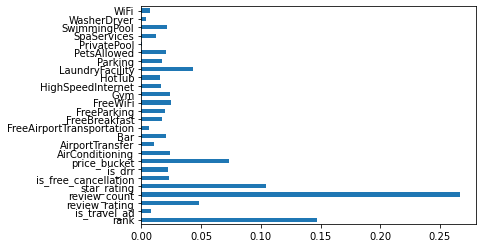

In [ ]:
# feature importances plot for transaction prediction
rf =RandomForestClassifier(n_estimators=130,min_samples_leaf=5,min_samples_split=3,random_state=40)
rf.fit(X1_train, y1_train)
(pd.Series(rf.feature_importances_, index=top_all_merge.columns).plot(kind='barh'))

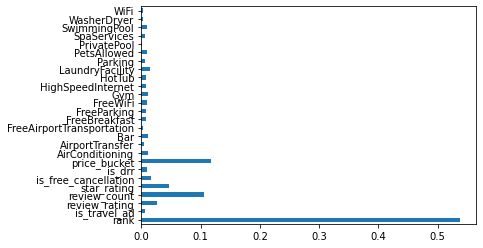

In [ ]:
# feature importances plot for click through prediction
rf =RandomForestClassifier(n_estimators=130,min_samples_leaf=5,min_samples_split=3,random_state=40)
rf.fit(X2_train, y2_train)
(pd.Series(rf.feature_importances_, index=top_all_merge.columns).plot(kind='barh'))